In [75]:
# By Ismael Valenzuela (@aboutsecurity / @thinkredactblue)

from scapy.all import *
import pandas as pd
import numpy as np
import seaborn as sns
import binascii
import matplotlib.pyplot as plt
import datetime
import socket

%matplotlib inline

In [76]:
def pcap_to_dataframe(pcap): 
    # Conversts pcap to dataframe    
    ip_fields = [field.name for field in IP().fields_desc]
    tcp_fields = [field.name for field in TCP().fields_desc]
    udp_fields = [field.name for field in UDP().fields_desc]

    dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

    my_df = pd.DataFrame(columns=dataframe_fields)
    for packet in pcap[IP]:
        field_values = []
        for field in ip_fields:
            if field == 'options':
                field_values.append(len(packet[IP].fields[field]))
            else:
                field_values.append(packet[IP].fields[field])
        
        field_values.append(packet.time)
        
        layer_type = type(packet[IP].payload)
        for field in tcp_fields:
            try:
                if field == 'options':
                    field_values.append(len(packet[layer_type].fields[field]))
                else:
                    field_values.append(packet[layer_type].fields[field])
            except:
                field_values.append(None)
        
        field_values.append(len(packet[layer_type].payload))
        field_values.append(packet[layer_type].payload.original)
        field_values.append(binascii.hexlify(packet[layer_type].payload.original))
        df_append = pd.DataFrame([field_values], columns=dataframe_fields)
        my_df = pd.concat([my_df, df_append], axis=0)

        # replace proto values with strings 'tcp' or 'udp'

        #df['proto'] = df['proto'].replace([6],'tcp')
        #df['proto'] = df['proto'].replace([17],'udp')

    my_df = my_df.reset_index()
    my_df["len"] = pd.to_numeric(my_df["len"])
    my_df["time"] = pd.to_numeric(my_df["len"])

    my_df = my_df.drop(columns="index")

    return my_df

In [77]:
# Read pcap files
pcap1 = rdpcap("../pcaps/generated_traffic_1.pcap")
pcap2 = rdpcap("../pcaps/generated_traffic_2.pcap")
pcap3 = rdpcap("../pcaps/generated_traffic_3.pcap")
pcap4 = rdpcap("../pcaps/generated_traffic_4.pcap")

# Create dataframes
df1 = pcap_to_dataframe(pcap1)
df2 = pcap_to_dataframe(pcap2)
df3 = pcap_to_dataframe(pcap3)
df4 = pcap_to_dataframe(pcap4)

proto
6     43
17     7
Name: src, dtype: int64


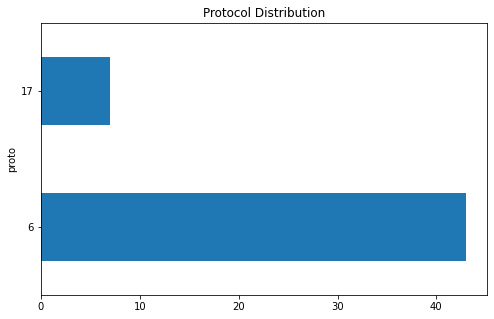

In [79]:
protocol_stats = df1.groupby("proto")['src'].count()
print(protocol_stats)
protocol_stats.plot(kind='barh',title="Protocol Distribution",figsize=(8,5))
plt.show()

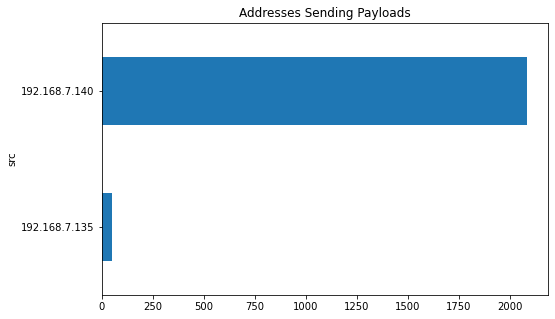

In [80]:
# Graph - Group by Source Address and Payload Sum

source_addresses = df1.groupby("src")['payload'].sum()
source_addresses.plot(kind='barh',title="Addresses Sending Payloads",figsize=(8,5))
plt.show()

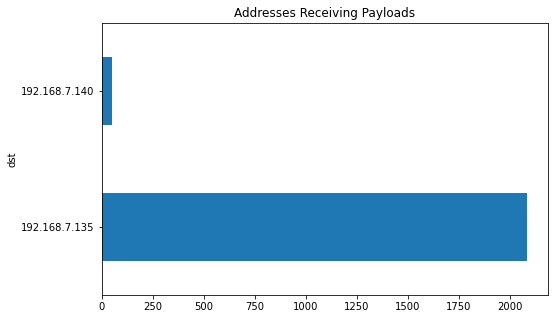

In [81]:
# Graph - Group by Dest Address and Payload Sum

dst_addresses = df1.groupby("dst")['payload'].sum()
dst_addresses.plot(kind='barh',title="Addresses Receiving Payloads",figsize=(8,5))
plt.show()

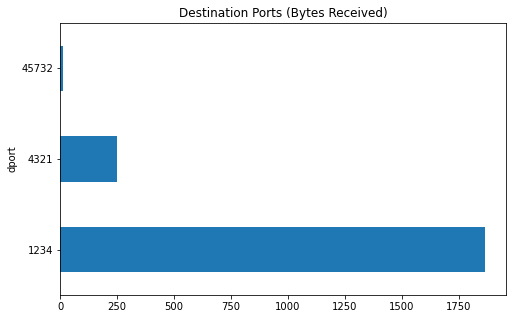

In [82]:
# Graph - Group by Destination Port and Payload Sum

destination_ports = df1.groupby("dport")['payload'].sum()
destination_ports.plot(kind='barh',title="Destination Ports (Bytes Received)",figsize=(8,5))
plt.show()

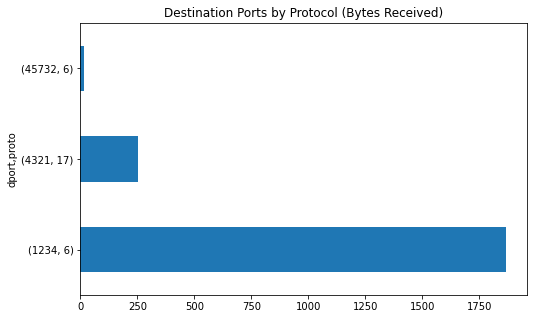

In [83]:
# Graph - Group by Destination Port, Protocol and Payload Sum

destination_payloads_proto = df1.groupby(["dport","proto"])['payload'].sum()
destination_payloads_proto.plot(kind='barh',title="Destination Ports by Protocol (Bytes Received)",figsize=(8,5))
plt.show()

In [84]:
# UDP length statistics
df1[df1['proto'] == 17].describe()

,len,time
count,7.000000,7.000000
mean,94.714286,94.714286
std,52.015108,52.015108
min,52.000000,52.000000
25%,52.000000,52.000000
50%,66.000000,66.000000
75%,138.500000,138.500000
max,164.000000,164.000000


In [85]:
# TCP length statistics
df1[df1['proto'] == 6].describe()

,len,time
count,41.000000,41.000000
mean,92.292683,92.292683
std,52.466772,52.466772
min,52.000000,52.000000
25%,52.000000,52.000000
50%,60.000000,60.000000
75%,164.000000,164.000000
max,164.000000,164.000000


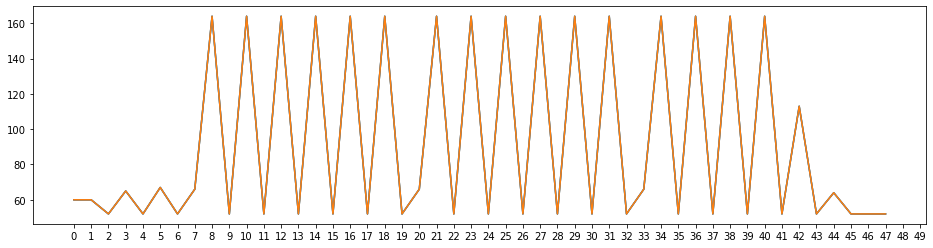

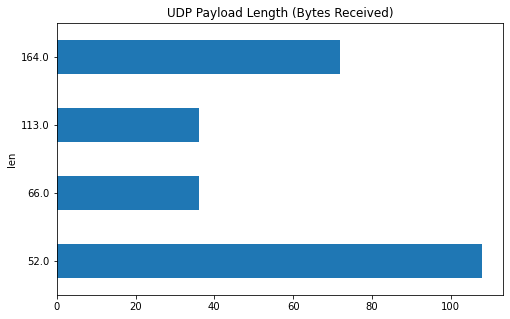

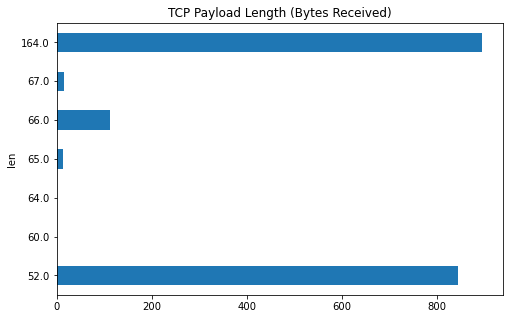

In [135]:
# Packet length visualizations
# Lenght does not include 14 bytes in Ethernet header (Wireshark will show total length inc. ethernet)
df1['len'].plot(figsize=(16,4))
df1['len'].plot(subplots=True, figsize=(16,4))
df1['len'].plot(y=['len'], figsize=(16,4))
plt.xticks(df1.index)
plt.show()

# UDP length 
udp_df = df1[df1['proto'] == 17]
destination_ports = udp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="UDP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP length
tcp_df = df1[df1['proto'] == 6]
destination_ports = tcp_df.groupby("len")['payload'].sum()
destination_ports.plot(kind='barh',title="TCP Payload Length (Bytes Received)",figsize=(8,5))
plt.show()

# TCP segment size by IP address

In [87]:
# Geocoordinates from several pcaps - payload
# Splitting the payload column into sets of 4 characters, and add them to new column
# Looking for similarities
def return_list_of_bytes(x,n):
    return [x[index : index + n] for index in range(0, len(x), n)]

df1['payload_array_raw'] = df1['payload_raw'].apply(lambda x: return_list_of_bytes(x,4))

df1['payload_array_raw'].iloc[10][0]

b'\xc0\xa8\x07\x8c'

<AxesSubplot:>

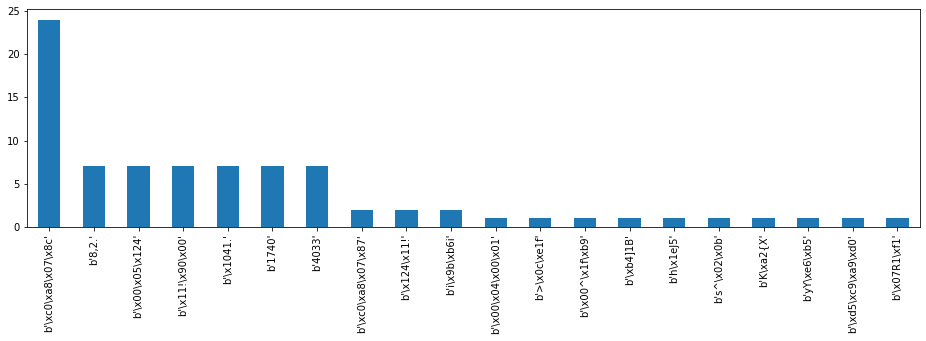

In [63]:
# Looking for similarities
# Create a Pandas Series with all values in Payload Bytes column
listbytes = pd.Series(df1['payload_array_raw'].explode())
listbytes.dropna(inplace=True)

# Visualize TOP 20 occurrences 
listbytes.value_counts().nlargest(20).plot.bar(figsize=(16,4))


In [88]:
# Search IP in payload - visualization
import socket
import re

# Convert an IP string to long
def long2ip(ip):
    return socket.inet_ntoa(ip)

# Take a list of bytes strings
def searchPayload(payload):
    payloadIps = []
    for p in payload:
        if len(p) % 4  == 0 and p != b'':
            ip = long2ip(p)
            payloadIps.append(ip)
    return payloadIps

# Creates a new column that is a pandas Series
df1['payload_ips'] = df1['payload_array_raw'].apply(lambda x: searchPayload(x))

<AxesSubplot:>

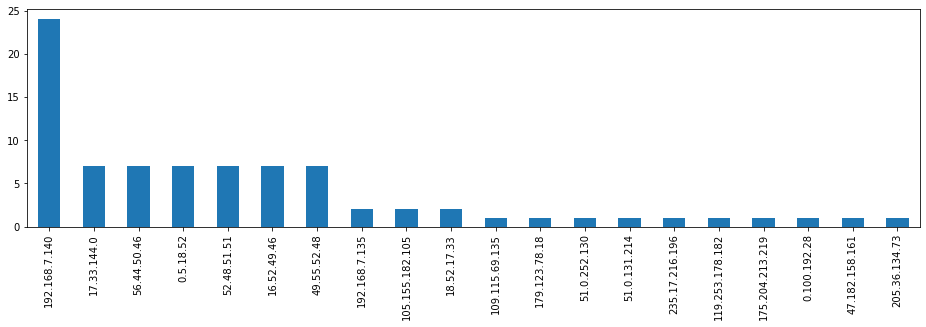

In [89]:
# Create a Pandas Series with all values in Payload IPs column
listIPs = pd.Series(df1['payload_ips'].explode())
listIPs.dropna(inplace=True)

# Visualize TOP 20 occurrences 
listIPs.value_counts().nlargest(20).plot.bar(figsize=(16,4))

In [132]:
# Additional filter - match IPs in payload that are shown in IP headers only
list_matchingIPs = []

def matchingIPs(pcap):
    for i in pcap:
        for j in listIPs:
            if (j == (i[IP].src)) or (j == (i[IP].dst)):
                    if j not in list_matchingIPs:
                        list_matchingIPs.append(j)

matchingIPs(pcap1)
list_matchingIPs


['192.168.7.140', '192.168.7.135']

In [90]:
# Find in what positions in the payload these IPs are found
# Payload_IPs is a column of panda series
# Iterate over the list of unique IPs and search for occurrances in row and position of the payload_ips column in the DF
for i in listIPs: 
        for j in range(df1['payload_ips'].str.len().max()): # Max length of all series under payload_IPs column 
            if ((df1['payload_ips'].str[j] == i).values.sum()) > 0: # Counts occurrances for position i inside series
                print ('IP address:',i,'found in position:',j,'times:',(df1['payload_ips'].str[j] == i).values.sum())

# -- Nice to have -- 
# Add to a list - sort most common
# Show hex payload as well
# Show hex payload that repeats with offset & packet nr

IP address: 192.168.7.140 found in position: 0 times: 24
IP address: 0.1.0.5 found in position: 1 times: 1
IP address: 18.52.17.33 found in position: 2 times: 2
IP address: 192.168.7.135 found in position: 0 times: 2
IP address: 0.2.0.5 found in position: 1 times: 1
IP address: 18.52.17.33 found in position: 2 times: 2
IP address: 192.168.7.140 found in position: 0 times: 24
IP address: 0.3.0.0 found in position: 1 times: 1
IP address: 0.5.18.52 found in position: 2 times: 7
IP address: 17.33.144.0 found in position: 3 times: 7
IP address: 16.52.49.46 found in position: 4 times: 7
IP address: 52.48.51.51 found in position: 5 times: 7
IP address: 56.44.50.46 found in position: 6 times: 7
IP address: 49.55.52.48 found in position: 7 times: 7
IP address: 51.0.214.78 found in position: 8 times: 1
IP address: 192.168.7.140 found in position: 0 times: 24
IP address: 0.4.0.16 found in position: 1 times: 1
IP address: 0.100.31.139 found in position: 2 times: 1
IP address: 8.0.146.193 found in 

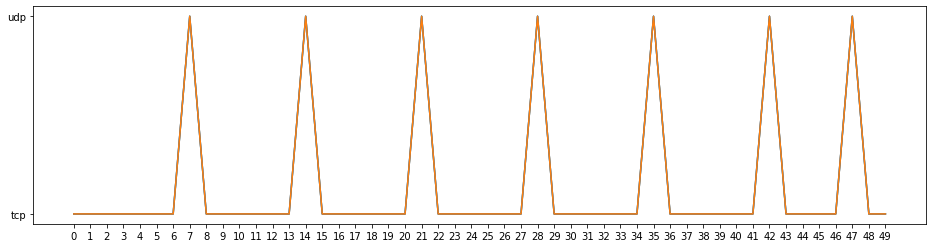

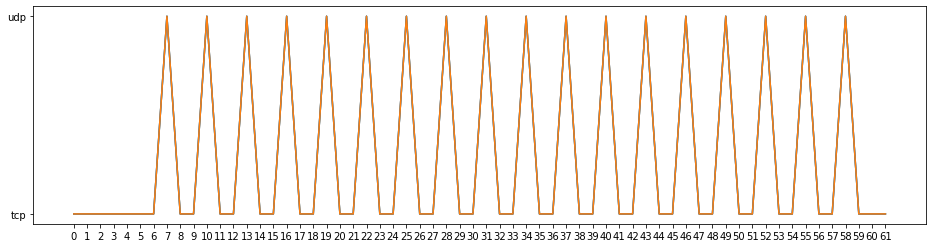

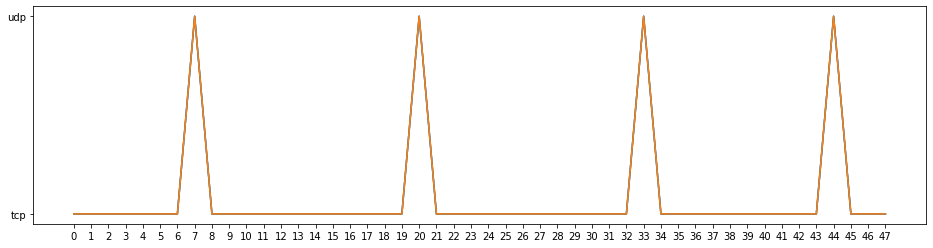

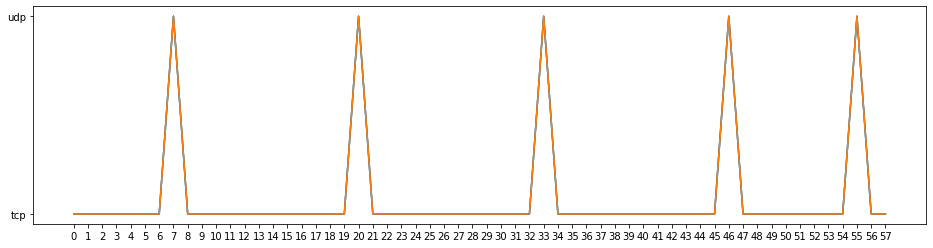

In [136]:
# Finding the heartbeat

df1['proto'].plot(figsize=(16,4))
df1['proto'].plot(subplots=True, figsize=(16,4))
df1['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df1.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

df2['proto'].plot(figsize=(16,4))
df2['proto'].plot(subplots=True, figsize=(16,4))
df2['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df2.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

df3['proto'].plot(figsize=(16,4))
df3['proto'].plot(subplots=True, figsize=(16,4))
df3['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df3.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

df4['proto'].plot(figsize=(16,4))
df4['proto'].plot(subplots=True, figsize=(16,4))
df4['proto'].plot(y=["proto"], figsize=(16,4))
plt.xticks(df4.index)
plt.yticks([6,17],['tcp','udp'])
plt.show()

# Notice the heartbeat packet
# Negotiation changes across runs
# Show this graph for the 3 pcaps

In [134]:
# Geolocation show UDP heartbeats payload in ASCII strings
# Based on our previous exploration we suspect the UDP packets carry the payloads
# Let's see what's in those payloads, using scapy's hexdump

for packet in pcap1[UDP]:
    print('\n')
    hexdump(packet.payload)

# Notice there's a string that repeats
# Google that! Those are coordinates!



0000  45 00 00 40 00 01 00 00 40 11 EA 48 C0 A8 07 8C  E..@....@..H....
0010  C0 A8 07 87 10 E1 10 E1 00 2C 50 07 C0 A8 07 8C  .........,P.....
0020  00 03 00 00 00 05 12 34 11 21 90 00 10 34 31 2E  .......4.!...41.
0030  34 30 33 33 38 2C 32 2E 31 37 34 30 33 00 D6 4E  40338,2.17403..N


0000  45 00 00 40 00 01 00 00 40 11 EA 48 C0 A8 07 8C  E..@....@..H....
0010  C0 A8 07 87 10 E1 10 E1 00 2C 63 2C C0 A8 07 8C  .........,c,....
0020  00 03 00 01 00 05 12 34 11 21 90 00 10 34 31 2E  .......4.!...41.
0030  34 30 33 33 38 2C 32 2E 31 37 34 30 33 00 C3 28  40338,2.17403..(


0000  45 00 00 40 00 01 00 00 40 11 EA 48 C0 A8 07 8C  E..@....@..H....
0010  C0 A8 07 87 10 E1 10 E1 00 2C 29 D1 C0 A8 07 8C  .........,).....
0020  00 03 00 02 00 05 12 34 11 21 90 00 10 34 31 2E  .......4.!...41.
0030  34 30 33 33 38 2C 32 2E 31 37 34 30 33 00 FC 82  40338,2.17403...


0000  45 00 00 40 00 01 00 00 40 11 EA 48 C0 A8 07 8C  E..@....@..H....
0010  C0 A8 07 87 10 E1 10 E1 00 2C 3C 6E C0 A8 07 8C  .

In [102]:
# Extract all coordinates from UDP payload and plot them in a map
import folium

COORD_map = folium.Map(zoom_start=12, 
tiles='cartodbpositron', width=640, height=480)

def packet_add_coordinates(pcap):
    for packet in pcap[UDP]:
        # Put in var decoded the UDP payload as a str
        decoded = (str(packet.payload[2]))
        print (re.findall(r'\d{1,2}\.\d+', decoded))
        folium.Marker(re.findall(r'\d{1,2}\.\d+', decoded)).add_to(COORD_map)

packet_add_coordinates(pcap1)
packet_add_coordinates(pcap2)
packet_add_coordinates(pcap3)
packet_add_coordinates(pcap4)

# Visualize map 

COORD_map

['41.40338', '2.17403']
['41.40338', '2.17403']
['41.40338', '2.17403']
['41.40338', '2.17403']
['41.40338', '2.17403']
['41.40338', '2.17403']
['41.40338', '2.17403']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['23.01667', '55.43333']
['41.40338', '2.17403']
['67.42809', '36.172826']
['67.42809', '36.172826']
['67.42809', '36.172826']
['41.40338', '2.17403']
['63.2', '31.51667']
['63.2', '31.51667']
['63.2', '31.51667']
['63.2', '31.51667']
['41.40338', '2.17403']
